#PIA PACEMAKER AI & OBJECT DETECTION

---  

**▶️ Live Clinic #6. Object Detection 개요**  
Live Clinic #7. Two-Stage 알고리즘 실습  
Live Clinic #8. One-Stage 알고리즘 실습  
Live Clinic #9. Custom 이미지 라벨링  
Live Clinic #10. Custom 이미지 학습 & 테스트  

---

# Object Detection 개요

학습목표:
- Object Detection 문제가 무엇인지, Classification 및 다른 CV 문제와 어떻게 다른지 이해하고 설명할 수 있다.
- Object Detection에서 사용하는 평가지표인 precision, recall, IOU, average precision에 대해 이해하고 설명할 수 있다.
- Two-Stage 방법과 One-Stage 방법의 차이에 대해 이해하고 설명할 수 있다.


## 1. Object Detection Problem

아래는 대표적인 Computer Vision 문제들입니다.


<img src = "https://files.ai-pool.com/d/DV8TLgkWsAEGsEs.jpg" width=650>


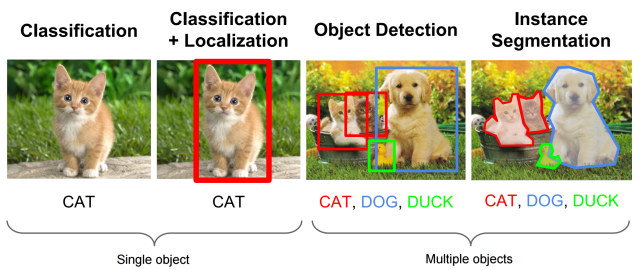

만약 Classification + Localization 문제를 인공신경망으로 푼다면 어떻게 하면 될까요?

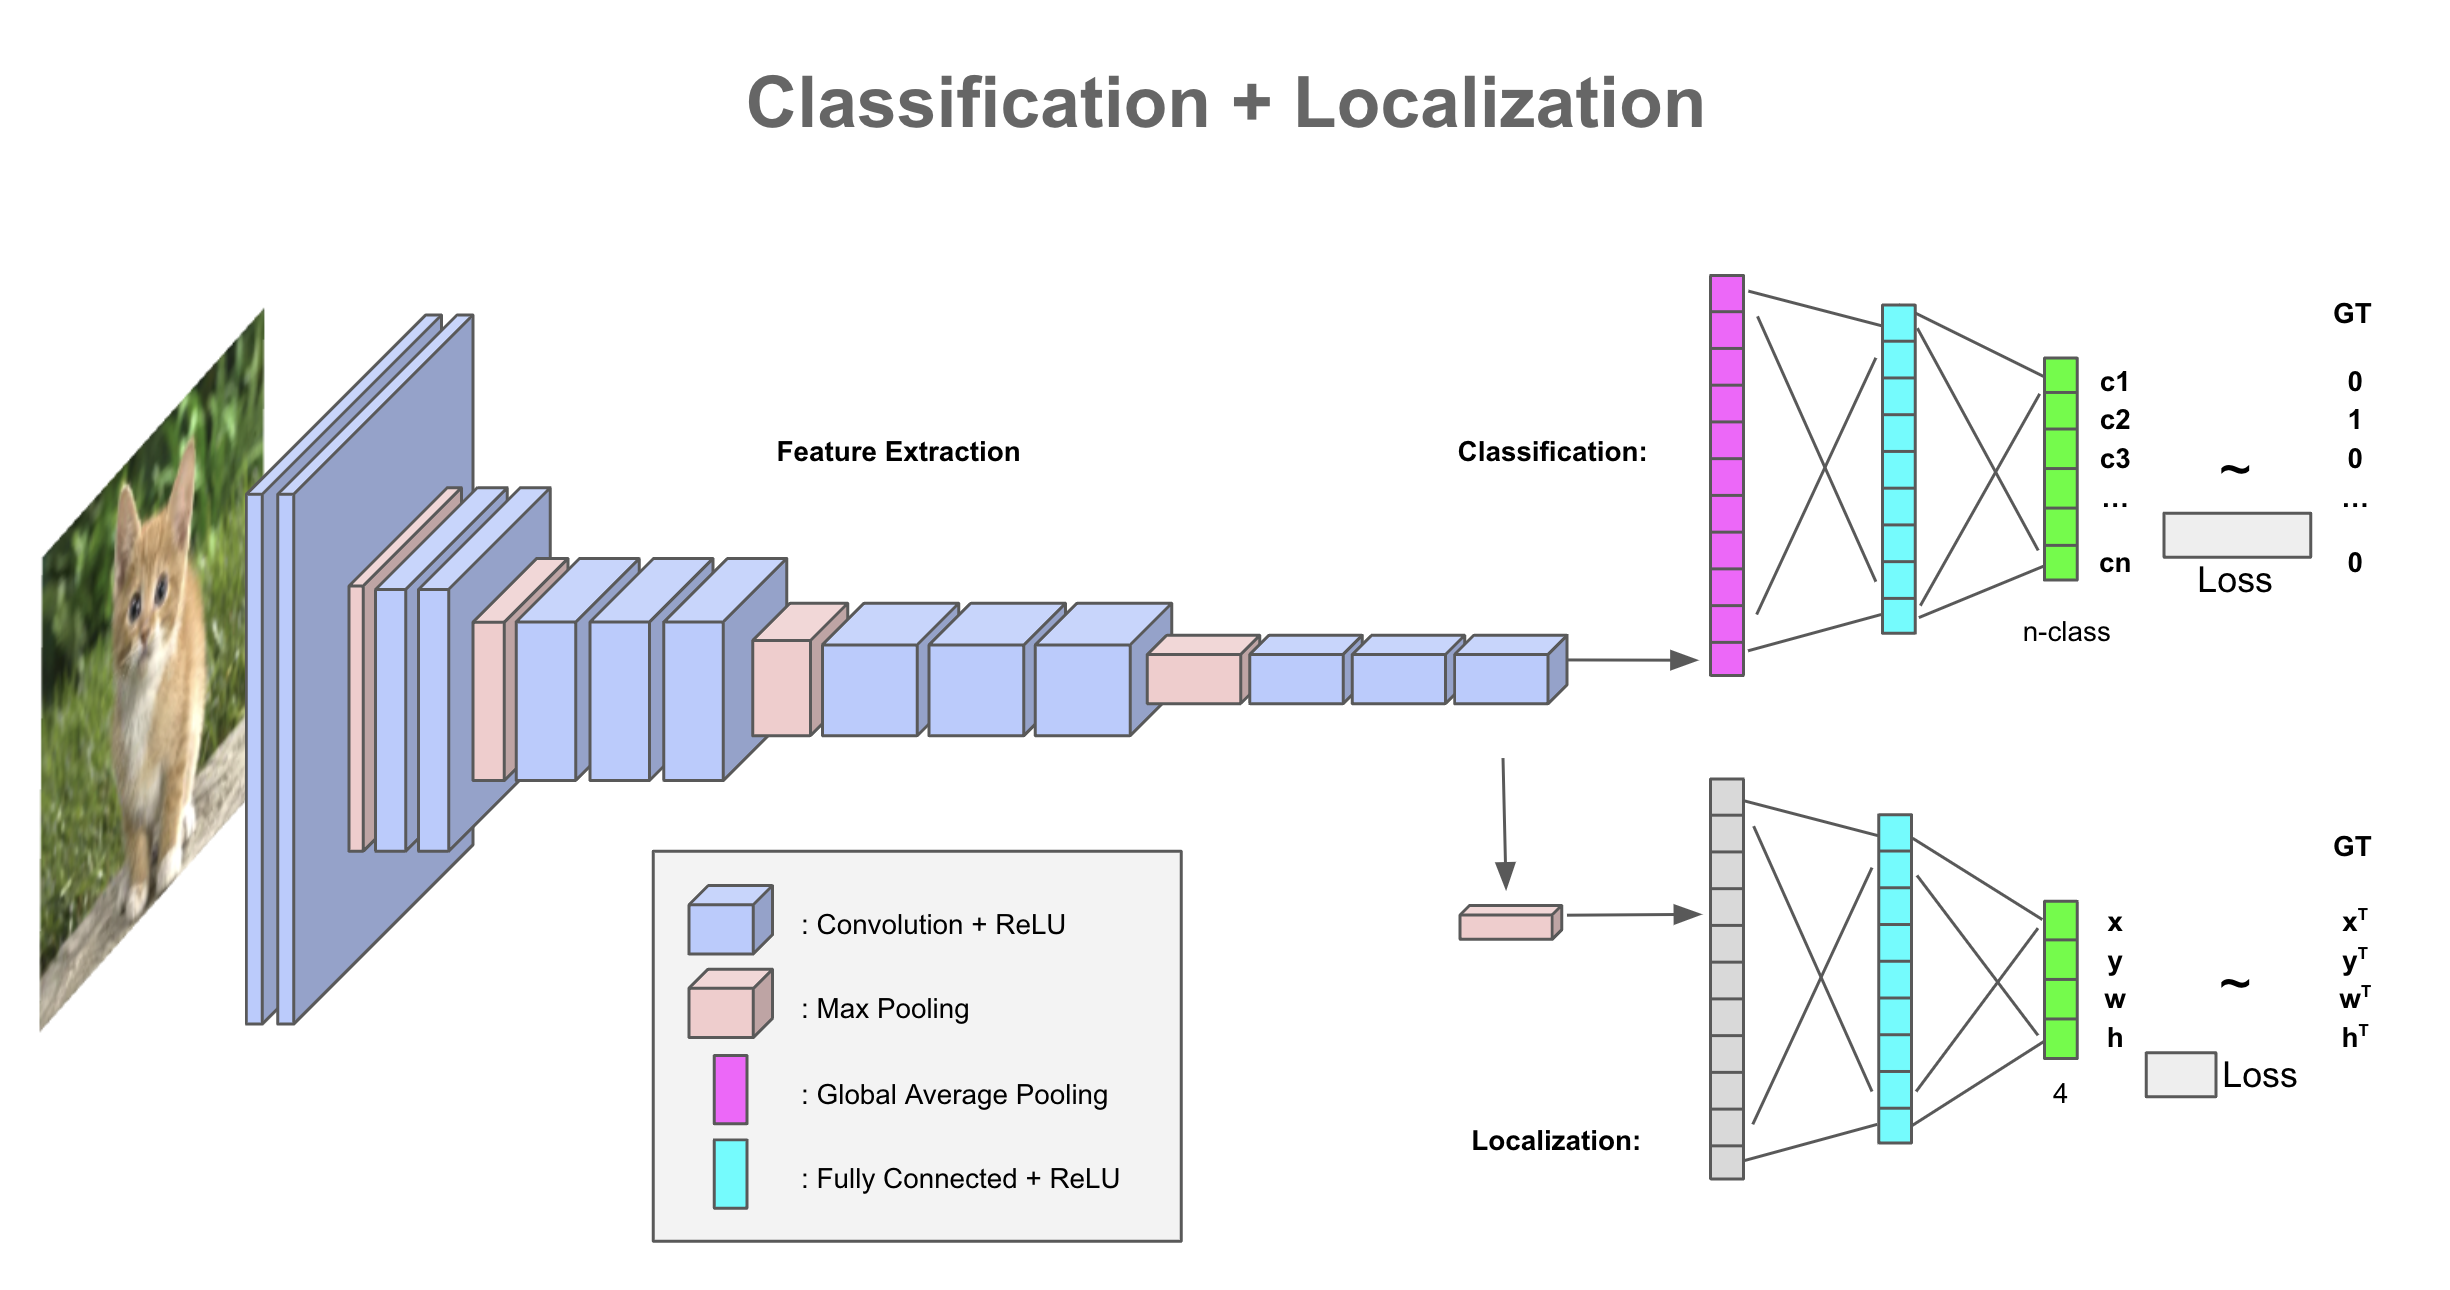

그렇다면 Object Detection도 위와 같은 방식으로 가능할까요??  

> Multi-object 문제라서 위와 같이 풀 수 없습니다.  
그럼 한꺼번에 많은 물체를 검출하기 위해 어떻게 문제를 접근할까요?  

> 전형적인 Object Detection 방법 (딥러닝 기반):  
1) 이미지를 Grid 로 분할한다.  
2) 각 Grid cell에 미리 정의한 크기와 비율을 가지는 anchor들을 적용한다.  
3) CNN 네트워크를 통해 특징을 검출한다. (feature map)  

> 4) Anchor 안에 (또는 근처에) 물체가 있는지의 여부와, 어디로 얼마큼 이동시켜야 물체와 일치하는지 상대좌표를 예측한다.  
5a) 이를 최종 결과로 삼고 동시에 물체의 종류도 알아낸다. **=> One-Stage 또는 Single-Stage 알고리즘**

> 5b) 위 정보를 후보 영역(region proposal)으로 사용하고, feature map에서 해당 영역을 가져온다.  
6) 잘라낸 영역으로 한번 더 예측을 수행하여 물체의 위치를 포착하고, 동시에 물체의 종류도 알아낸다. **=> Two-Stage 알고리즘**  
&nbsp;&nbsp;&nbsp; -> 5) ~ 6) 번을 반복 수행한다.  **=> Multi-Stage 알고리즘**  
  
> 7) (공통) NMS (Non-Maximum Suppression)을 통해 중복을 제거하고 최종 탐지 결과를 얻는다.
  
자세한 내용은 뒤에서 다시 다루도록 합니다.  


In [ ]:
# 여기서 잠깐!!
# 이미지에 박스를 한번 그려보고 가겠습니다.
# 먼저 이미지를 가져오는 코드입니다. 웹에 있는 이미지를 Colab 로컬로 다운로드 받습니다. (세선 종료 후 사라짐)

!wget https://github.com/PiaMentor/Pacemaker_AI/raw/main/w6_catdog.jpg -O catdog.jpg


--2022-06-23 12:09:17--  https://github.com/PiaMentor/Pacemaker_AI/raw/main/w6_catdog.jpg
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/PiaMentor/Pacemaker_AI/main/w6_catdog.jpg [following]
--2022-06-23 12:09:17--  https://raw.githubusercontent.com/PiaMentor/Pacemaker_AI/main/w6_catdog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32576 (32K) [image/jpeg]
Saving to: ‘catdog.jpg’

catdog.jpg          100%[===================>]  31.81K  --.-KB/s    in 0s      

2022-06-23 12:09:17 (117 MB/s) - ‘catdog.jpg’ saved [32576/32576]



이미지 크기: (561, 728, 3)


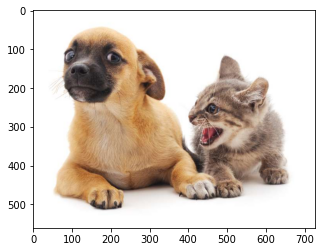

In [ ]:
import cv2
import matplotlib.pyplot as plt

# 이미지 그리기
img = cv2.imread('/content/catdog.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print('이미지 크기:', img.shape)

plt.imshow(img)
plt.show()

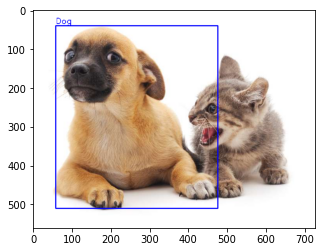

In [ ]:
x1, y1 = (58, 40)
x2, y2 = (475, 510)

# 이미지에 박스 삽입
img_box = img.copy()
img_box = cv2.rectangle(img_box, (x1, y1), (x2, y2), (0, 0, 255), 2)   # (x1, y1), (x2, y2)

# 이미지에 텍스트 삽입
img_box = cv2.putText(img_box, 'Dog', (x1, y1-5), cv2.FONT_HERSHEY_DUPLEX, 0.7, (0, 0, 255))

plt.imshow(img_box)
plt.show()

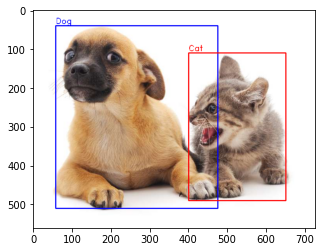

In [ ]:
x1, y1 = (400, 110)
x2, y2 = (650, 490)

# 이미지에 박스 삽입
img_box2 = img_box.copy()
img_box2 = cv2.rectangle(img_box2, (x1, y1), (x2, y2), (255, 0, 0), 2)   # (x1, y1), (x2, y2)

# 이미지에 텍스트 삽입
img_box2 = cv2.putText(img_box2, 'Cat', (x1, y1-5), cv2.FONT_HERSHEY_DUPLEX, 0.7, (255, 0, 0))

plt.imshow(img_box2)
plt.show()

지금 우리가 박스를 그리기 위해 사용한 좌표계는 Pixel 좌표계에 해당됩니다.  
OpenCV에서는 (x, y) 처럼 x 방향을 먼저 나타냅니다.  
numpy 또는 tensor 객체를 다룰 때와는 다른 점에 유의하세요.  

## 2. 평가지표 이야기

객체 인식을 얼마나 잘 하는지 평가하기 위해서는 지표가 필요합니다.  
먼저 첫 시간에 배웠던 TP, FP, FN, TN을 Detection 버전으로 다시 정의해 보겠습니다.


### 2.1 TP, FP, FN, TN

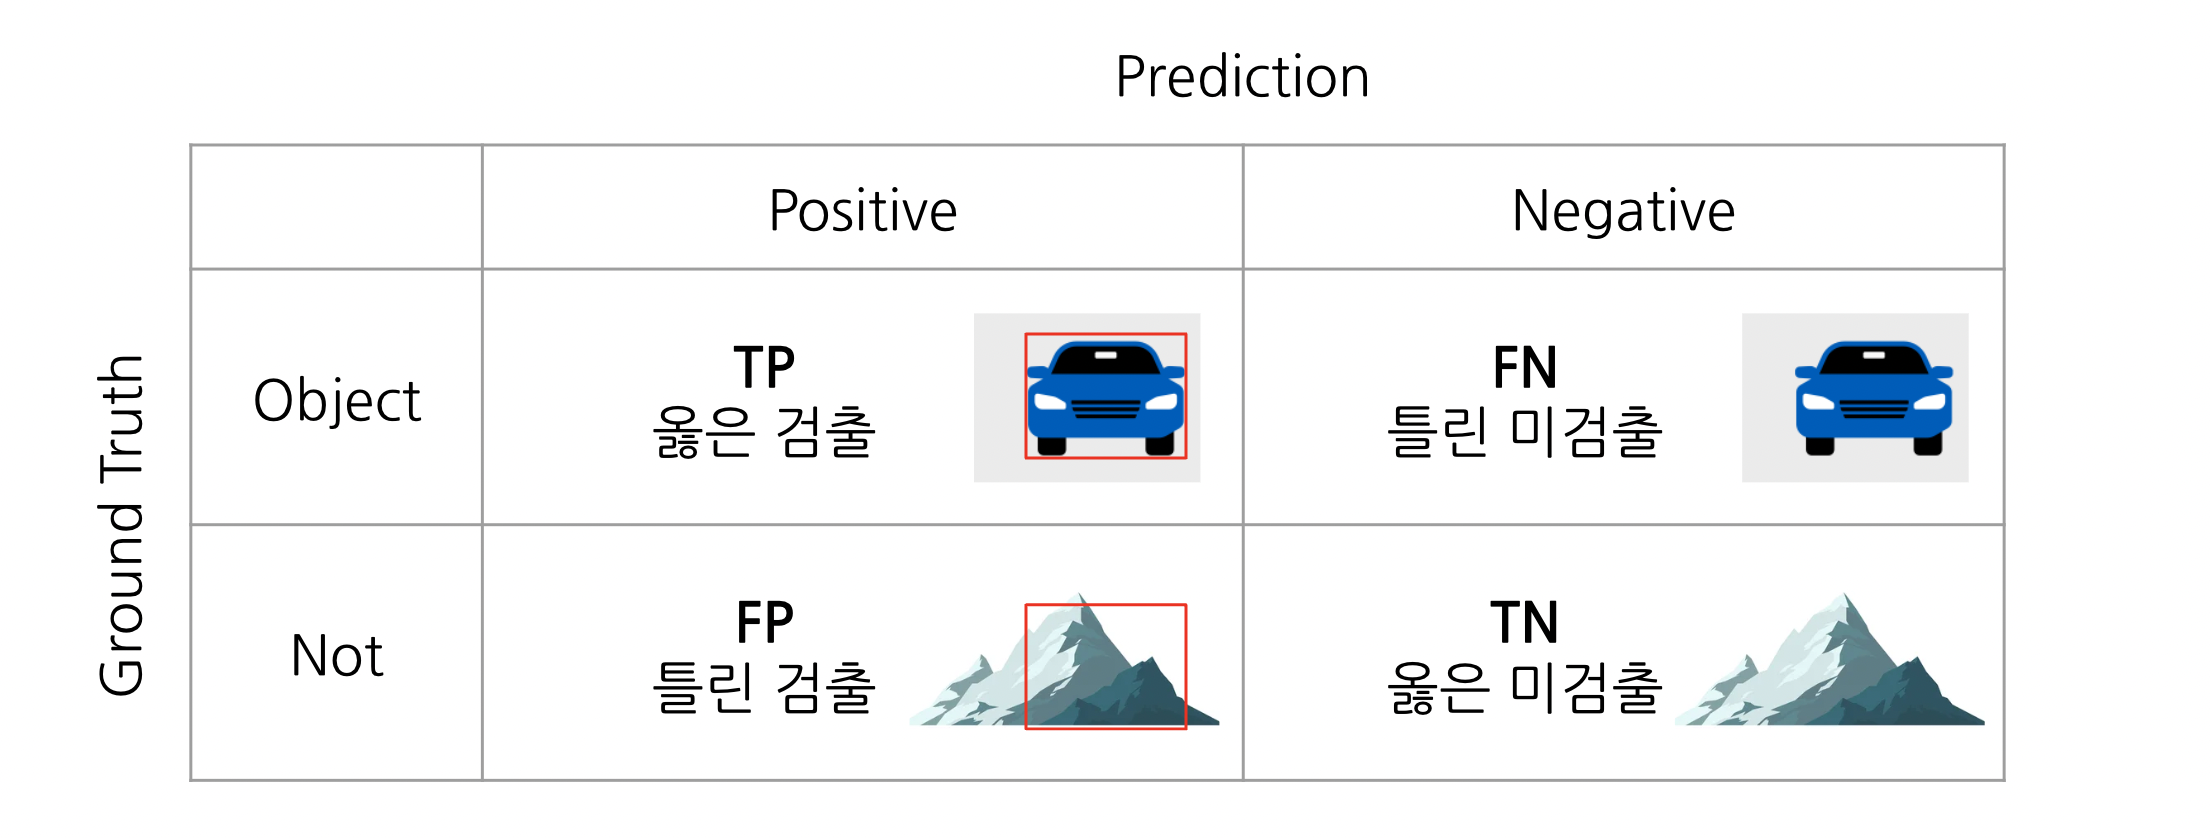

### 2.2 Precision, Recall

이제 Precision과 Recall을 정의해 보겠습니다.

- Precision: 정밀도. Positive로 예측한 것 중 정답 비율. 나의 예측이 얼마나 정확한가?

- Recall: 재현율. 정답 중 탐지한 것의 비율. 얼마나 많이 찾았는가?


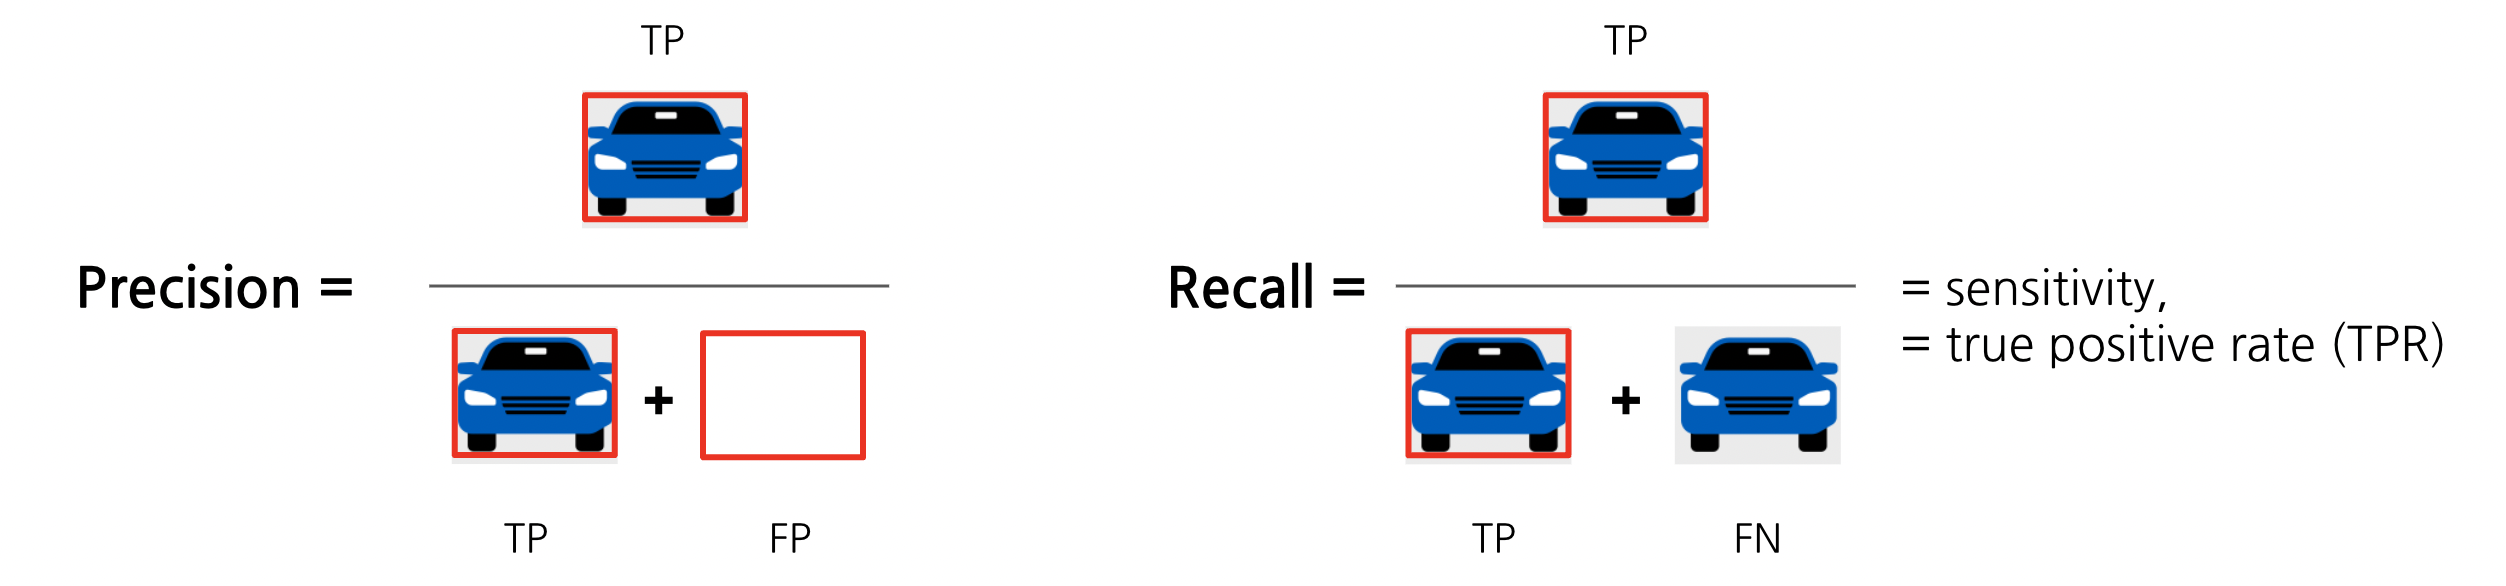

### 2.3 Average Precision


Precision과 Recall은 서로 trade-off 관계가 있습니다.  
Precision을 높이기 위해서는 confidence threshold를 높이면 되는데, 그렇게 되면 recall이 줄어들죠.  
반대로 confidence threshold를 낮추면 recall은 올라가지만 FP 발생이 많아져서 precision이 줄어듭니다.  

결국 어느 하나의 지표만으로 성능을 논하기에는 부족함이 있어서 우리는 여기서 또다른 개념을 도입합니다.  
Recall과 Precision을 동시에 고려한 개념으로 **Average Precision**이 있습니다.  
Threshold를 변화시켜 가면서 recall과 precision의 변화를 동시에 관찰하고, 이들 관계를 그레프로 나타냅니다.  
x축을 recall, y축을 precision으로 하는 그래프를 precision - recall curve 라고 합니다.  
이 그래프의 아래 면적을 우리는 **Average Precision** 또는 **AP**라고 정의합니다.  

### 2.4 예제로 AP 구해보기

Detection 결과 예제를 가지고 Precision, Recall, Average Precision을 구해보는 연습을 해볼까요?  

아래와 같이 10개의 detection이 발생했고, 각 detection의 confidence와 정답여부가 주어졌다고 가정하겠습니다.  
이 때, 검출해야 할 전체 정답 객체 수는 15개라고 가정합니다.


In [ ]:
import pandas as pd
from collections import namedtuple

# 검출결과 예:
DetPred = namedtuple('Detection', ['ID', 'confidence', 'TP'])
results = []

results.append(DetPred('A', 0.57, True))
results.append(DetPred('B', 0.78, True))
results.append(DetPred('C', 0.43, False))
results.append(DetPred('D', 0.85, True))
results.append(DetPred('E', 0.91, True))
results.append(DetPred('F', 0.13, False))
results.append(DetPred('G', 0.45, True))
results.append(DetPred('H', 0.68, False))
results.append(DetPred('I', 0.95, True))
results.append(DetPred('J', 0.81, True))

df = pd.DataFrame(results, columns=['ID', 'confidence', 'TP'])

df

ID  confidence     TP
0  A        0.57   True
1  B        0.78   True
2  C        0.43  False
3  D        0.85   True
4  E        0.91   True
5  F        0.13  False
6  G        0.45   True
7  H        0.68  False
8  I        0.95   True
9  J        0.81   True

In [ ]:
# confidence score에 따라 내림차순 정렬 (threshold 변화에 따라 계산하기 쉽도록)

df = df.sort_values(by='confidence', ascending=False)

df

ID  confidence     TP
8  I        0.95   True
4  E        0.91   True
3  D        0.85   True
9  J        0.81   True
1  B        0.78   True
7  H        0.68  False
0  A        0.57   True
6  G        0.45   True
2  C        0.43  False
5  F        0.13  False

In [ ]:
# 누적 TP, FP 갯수 구하기
tps = df['TP'].cumsum()
fps = (~df['TP']).cumsum()

df['TPs'] = tps
df['FPs'] = fps

df

ID  confidence     TP  TPs  FPs
8  I        0.95   True    1    0
4  E        0.91   True    2    0
3  D        0.85   True    3    0
9  J        0.81   True    4    0
1  B        0.78   True    5    0
7  H        0.68  False    5    1
0  A        0.57   True    6    1
6  G        0.45   True    7    1
2  C        0.43  False    7    2
5  F        0.13  False    7    3

In [ ]:
# Precision과 Recall의 변화 관찰
num_of_ground_truth = 15

precisions = df['TPs'] / (df['TPs'] + df['FPs'])
recalls = df['TPs'] / num_of_ground_truth

df['precision'] = precisions
df['recall'] = recalls

df

ID  confidence     TP  TPs  FPs  precision    recall
8  I        0.95   True    1    0   1.000000  0.066667
4  E        0.91   True    2    0   1.000000  0.133333
3  D        0.85   True    3    0   1.000000  0.200000
9  J        0.81   True    4    0   1.000000  0.266667
1  B        0.78   True    5    0   1.000000  0.333333
7  H        0.68  False    5    1   0.833333  0.333333
0  A        0.57   True    6    1   0.857143  0.400000
6  G        0.45   True    7    1   0.875000  0.466667
2  C        0.43  False    7    2   0.777778  0.466667
5  F        0.13  False    7    3   0.700000  0.466667

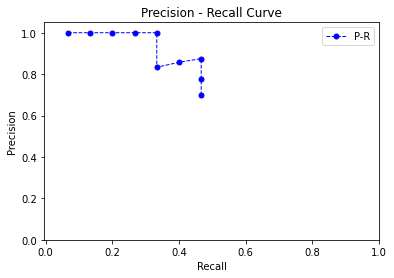

In [ ]:
# 그래프로 표현
plt.figure()
plt.plot(recalls, precisions, label="P-R", color="blue",
         lw=1, linestyle="--", marker='o', markersize=5)
plt.xlim([-0.005, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision - Recall Curve")
plt.legend(loc="upper right")
plt.show()

뭔가 허전하니까 조금 더 작업을 해보죠.  
P-R point들을 둘러싼 완전한 형태의 P-R Curve를 구해봅니다.

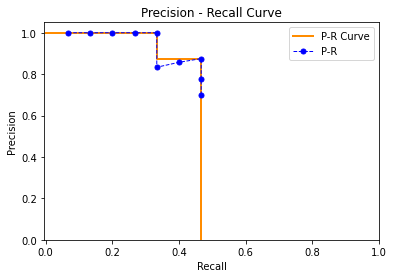

In [ ]:
# 시작점, 끝점 만들어주기
extended_precisions = list(precisions)
extended_recalls = list(recalls)
extended_precisions = [1.0] + extended_precisions + [0.0]
extended_recalls = [0.0] + extended_recalls + extended_recalls[-1:]

# precision을 우측의 높은 값으로 smoothing
max_p = 0.0
rev_pre = list(reversed(extended_precisions))
for i, p in enumerate(rev_pre):
  if p > max_p:
    max_p = p
  else:
    rev_pre[i] = max_p
extended_precisions = list(reversed(rev_pre))

# 다시 그래프 그리기
plt.figure()
plt.plot(extended_recalls, extended_precisions, label="P-R Curve",
         color="darkorange", lw=2)
plt.plot(recalls, precisions, label="P-R", color="blue",
         lw=1, linestyle="--", marker='o', markersize=5)
plt.xlim([-0.005, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision - Recall Curve")
plt.legend(loc="upper right")
plt.show()

이제 다 왔습니다. 면적만 구하면 그게 바로 Average Precision입니다.


In [ ]:
# 면적 계산
area = 0.0

for i in range(len(extended_recalls) - 1):
  dx = extended_recalls[i+1] - extended_recalls[i]
  y = extended_precisions[i+1]
  area += dx * y

# AP = PR-Curve 아래 면적
print('Average Precision (AP) =', area)


Average Precision (AP) = 0.44999999999999996


### 2.5 IoU (Intersection Over Union)

Object Detection 문제에서는 물체의 위치를 얼마나 정확하게 탐지했는지의 여부도 중요한 성능 지표가 됩니다.  

예측한 bounding box가 정답 bounding box와 얼마나 겹쳐있는지를 IoU로 평가합니다.  
IoU는 예측과 정답 박스의 겹친 영역 (intersection) / 합친 영역 (union) 으로 정의합니다.  

$$IOU = {Intersection \over Union} = {{BBox}_{pred} \cap {BBox}_{truth} \over {{BBox}_{pred} \cup {BBox}_{truth}}} $$


<img src = "https://img.laserfocusworld.com/files/base/ebm/lfw/image/2022/02/2202LFW_sto_1.61fbe61ac5f4a.png" width=700>

<image src="https://t1.daumcdn.net/cfile/tistory/994889425D14A35816" width=700>

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# 박스 설정
gt_box = (10, 10, 80, 85)   # (x1, y1, x2, y2)
pd_box = (30, 25, 95, 90)


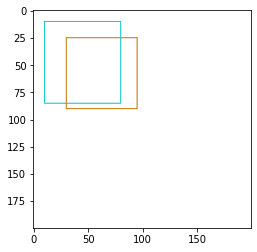

In [ ]:
# 화면에 그리기
img = np.ones((200, 200, 3))
img = cv2.rectangle(img, gt_box[:2], gt_box[2:], (.1, .8, .8), 1)
img = cv2.rectangle(img, pd_box[:2], pd_box[2:], (.8, .5, .1), 1)
plt.imshow(img)
plt.show()

In [ ]:
# IOU 구하기 연습

gt_area = (gt_box[2] - gt_box[0] + 1) * (gt_box[3] - gt_box[1] + 1)
pd_area = (pd_box[2] - pd_box[0] + 1) * (pd_box[3] - pd_box[1] + 1)

inter_width = np.maximum(0, np.minimum(gt_box[2], pd_box[2]) - np.maximum(gt_box[0], pd_box[0]) + 1)
inter_height = np.maximum(0, np.minimum(gt_box[3], pd_box[3]) - np.maximum(gt_box[1], pd_box[1]) + 1)
inter_area = inter_width * inter_height

union_area = gt_area + pd_area - inter_area

iou = inter_area / union_area

print(gt_area, pd_area, inter_area, union_area)
print('iou:', iou)


5396 4356 3111 6641
iou: 0.46845354615268786


## 3. Two-Stage Algorithms

Object Detection의 역사는 딥러닝 이전과 이후로 나뉜다고 해도 과언이 아닙니다.  
딥러닝이 적용되면서 성능의 획기적인 향상도 있었지만, 무엇보다 detection 방식 자체가 많이 바뀌었죠.  
기존 방식과의 차이에 대해서는 여기서 자세히 다루지는 않겠지만, 개략적인 딥러닝 방식의 Object Detection 과정은 본 문서의 앞부분을 참고하시기 바랍니다.  


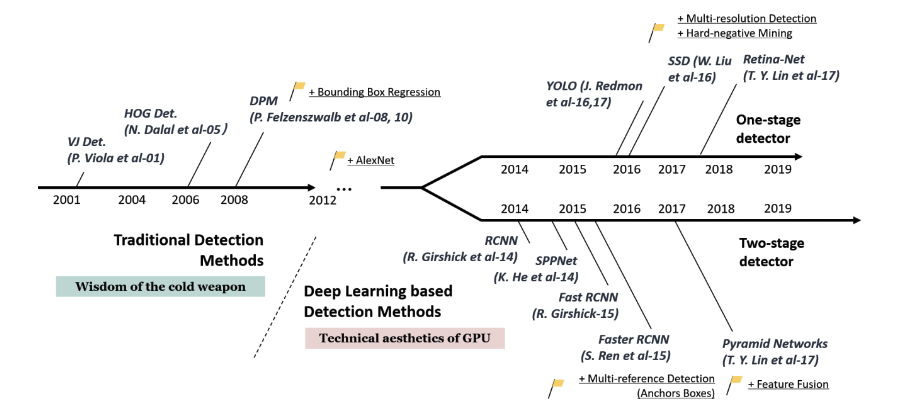

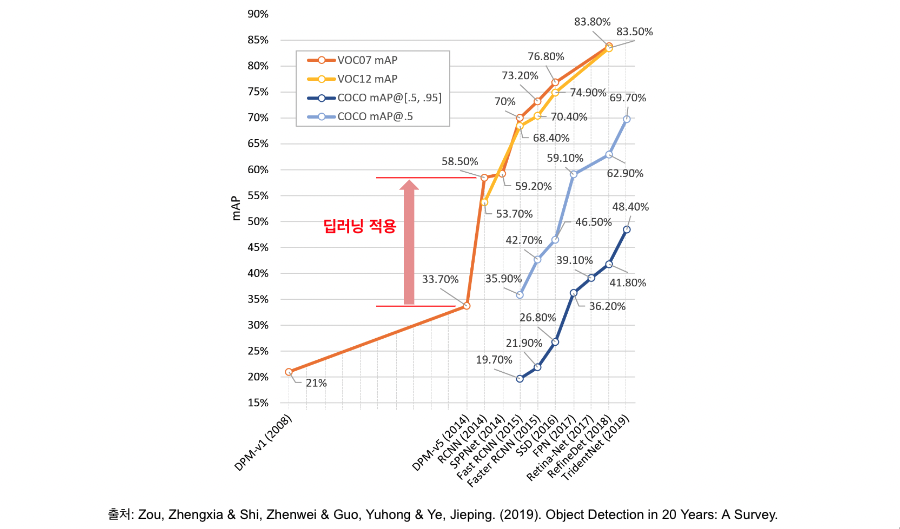

딥러닝이 처음 적용되면서 제시된 알고리즘은 Two-stage 알고리즘입니다.  
첫 단계에서 물체의 후보가 되는 영역을 찾고 (region proposal 또는 ROI), 두 번째 단계에서 후보 영역을 분류하고 조정하는 방식으로 작동합니다.  

RCNN(region based CNN)부터 -> Fast RCNN -> Faster RCNN으로 이어진 계보는 Object Detection에 딥러닝이 적용되는 역사적인 과정을 보여줍니다.  
RCNN, Fast RCNN은 과도기적인 모습을 보이고 있고, Faster RCNN에 와서는 전과정에 걸쳐 딥러닝이 적용되었습니다.  

이후 많은 연구들이 계속 쏟아져 나오고 있고, 현재도 많은 곳에서 Two-stage 알고리즘을 사용하고 있습니다.  

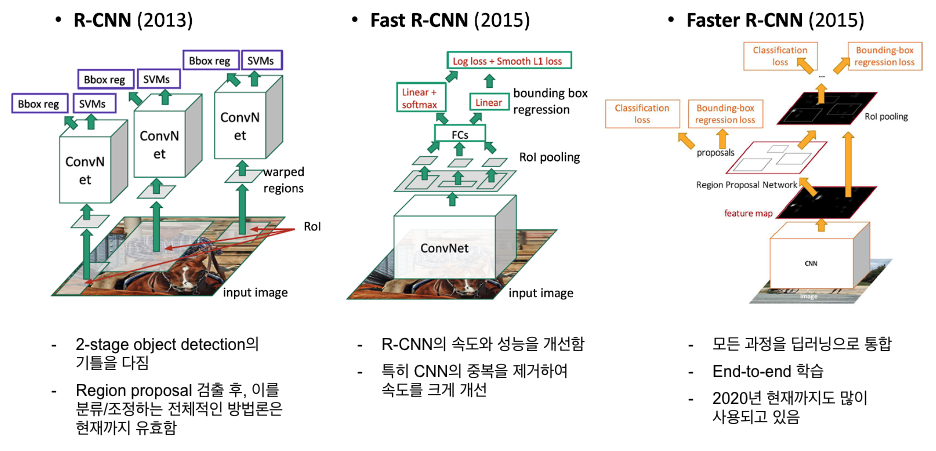

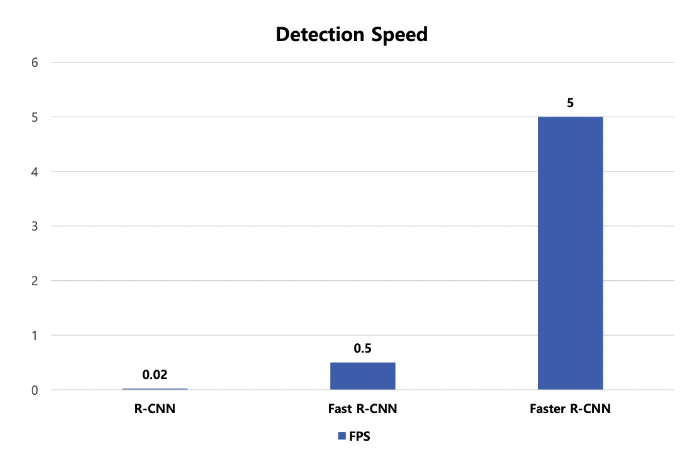

아래는 Faster R-CNN의 작동 방식을 anchor를 사용하여 보다 자세히 보여줍니다.  

앞으로 직접 실습해 볼 예정입니다. (Live Clinic #7)

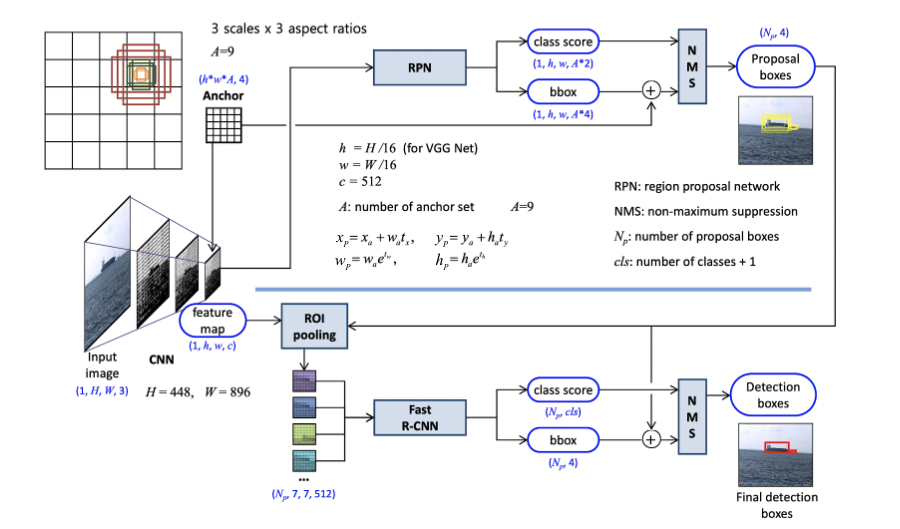

## 4. One-Stage Algorithms

속도를 향상시키기 위해 One-stage 또는 Sigle-stage 알고리즘이 나오기 시작했습니다.  

사진에서 물체가 차지하는 비중이 작아서 겪을 수밖에 없는 문제를 (통계학적으로 표현하자면 prior가 낮은 문제) 여러 기법들로 해결하면서 한 번의 수행만으로도 좋은 성능을 달성하게끔 하고, 속도는 확실히 증가시키는 그런 알고리즘들입니다.  

SSD(Single Stage Detector)와 YOLO(You Only Look Once)는 대표적인 One-stage 알고리즘입니다.  
YOLO의 경우 원 저자가 v2, v3까지 개발하며 성능과 속도를 향상시켰고, 그 이후 v4, v5까지 나오며 계보가 이어지고 있습니다.  

아래는 YOLO (v1)의 탐지방식입니다.  

CNN을 한 번만 통과시키면 출력 텐서에 grid cell 별로 모든 탐지 정보 (위치, 종류)가 담기게끔 됩니다.  
NMS를 통해 중복을 제거하여 최종 탐지결과를 얻습니다.  

YOLO v3 버전을 직접 실습해볼 예정입니다. (Live Clinic #8)  


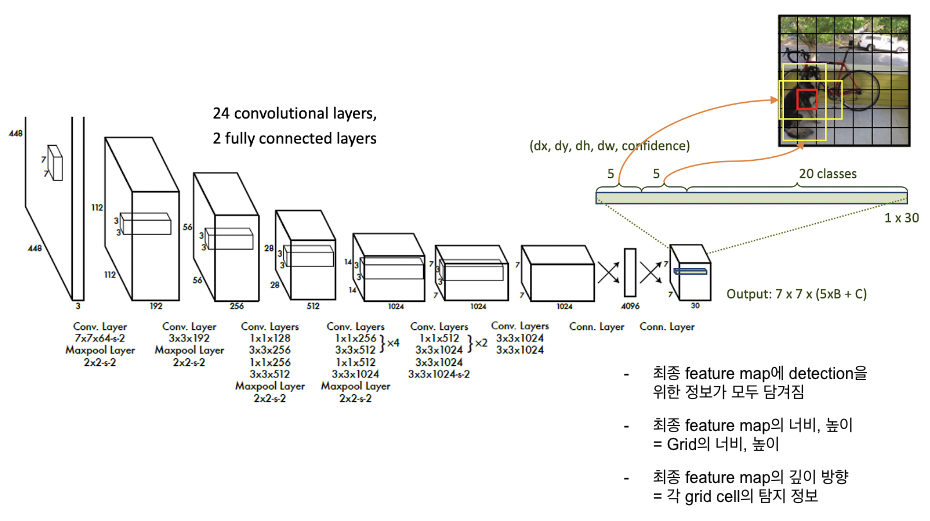

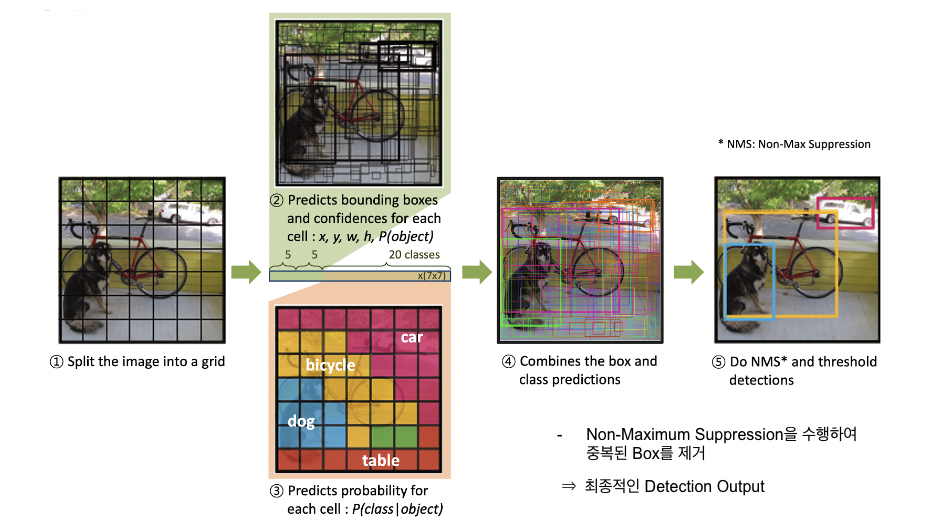

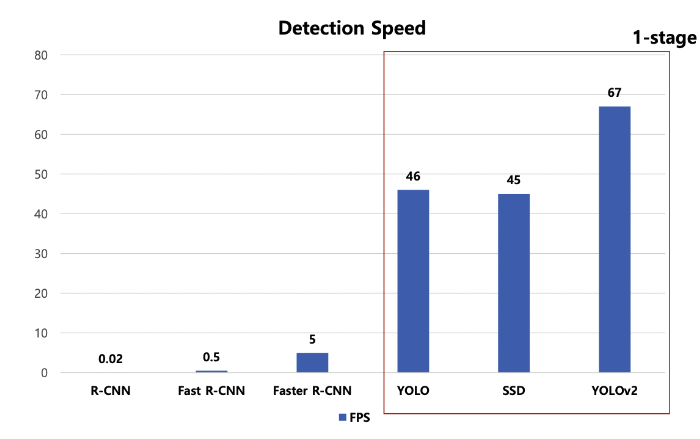

One-stage (Single-stage) 알고리즘은 속도가 빠르다는 장점이 있지만 일반적으로 Two-stage 알고리즘에 비해 성능은 다소 떨어집니다.  
특히 밀집된 작은 물체들에 대해서는 약한 성능을 보입니다.  

원하는 용도와 조건에 맞게 알고리즘을 선택하여 사용하면 되겠습니다.  

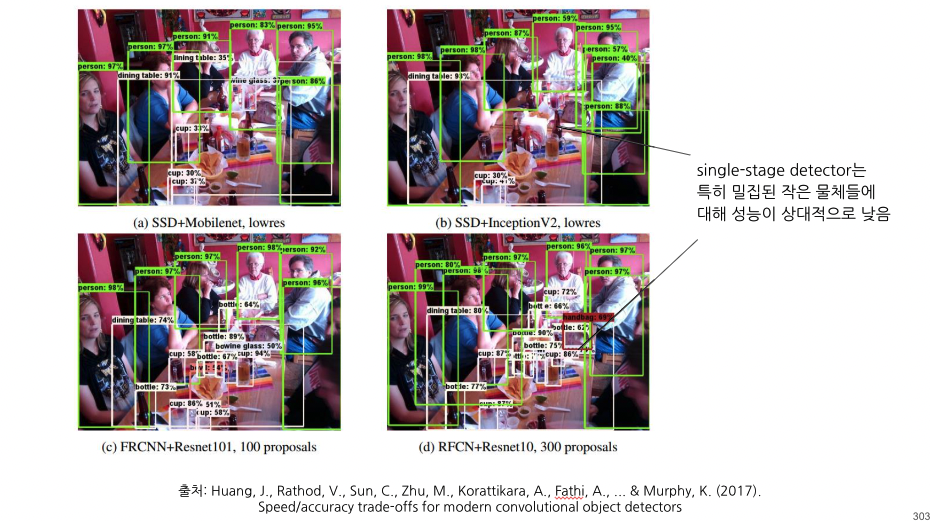